In [ ]:


!unzip digits.zip


#Test for better code

In [ ]:
# generate_features_2.py

import os
import numpy as np
from PIL import Image
from collections import deque
import pandas as pd
import time

# Configuration
SAMPLES_PER_NUMBER = 1000 # Change to 1000 for better accuracy if you have enough images
BASE_DIR = './digits'    # Change this to the path where your 'digits' folder is located
OUTPUT_CSV = 'digit_features_2.csv' # <-- Output file name

# Image dimensions
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

# BFS Threshold - What pixel value (0-1) is considered 'black' or traversable?
# This MUST be the SAME value used in your Colab notebook (Cell 1 & Cell 2).
BFS_THRESHOLD = 0.08 # Adjust this value if needed, based on your image characteristics.


def image_to_matrix(image_path):
    """
    Loads a grayscale image and converts it to a 28x28 numpy array
    with values between 0 (black) and 1 (white), like the JS code.
    Assumes input is black digit on white background, or white on black.
    Scales raw 0-255 values to 0-1.
    """
    try:
        img = Image.open(image_path).convert('L') # Convert to grayscale
        if img.size != (IMAGE_WIDTH, IMAGE_HEIGHT):
            # print(f"Warning: Resized image {image_path} from {img.size} to {IMAGE_WIDTH}x{IMAGE_HEIGHT}")
            img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.Resampling.LANCZOS)

        # Get pixel data, flatten, convert to float, scale to 0-1
        pixels = np.array(img).astype(np.float32) / 255.0

        # Reshape to 28x28 matrix (y, x)
        matrix = pixels.reshape((IMAGE_HEIGHT, IMAGE_WIDTH))

        return matrix

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


# Modified BFS function with threshold
def bfs(matrix, direction_func_index, threshold=BFS_THRESHOLD):
    """
    Performs Breadth-First Search on the matrix using a threshold for traversal.
    Traverses pixels where matrix value is < threshold (considered "black").
    """
    rows, cols = matrix.shape
    visited = np.full((rows, cols), False, dtype=bool)
    queue = deque()

    def enqueue_if_valid(x, y):
        # Ensure x and y are within bounds
        if 0 <= x < cols and 0 <= y < rows:
            # Check if not visited and pixel value is BELOW the threshold
            if not visited[y, x] and matrix[y, x] < threshold: # <--- Changed condition
                queue.append((x, y))
                visited[y, x] = True

    # Equivalent direction functions from JS
    def top_pour_neighbors(x, y): # JS index 0
        enqueue_if_valid(x - 1, y) # Left
        enqueue_if_valid(x + 1, y) # Right
        enqueue_if_valid(x, y - 1) # Up

    def bottom_pour_neighbors(x, y): # JS index 1
        enqueue_if_valid(x - 1, y) # Left
        enqueue_if_valid(x + 1, y) # Right
        enqueue_if_valid(x, y + 1) # Down

    def left_pour_neighbors(x, y): # JS index 2
        enqueue_if_valid(x - 1, y) # Left
        enqueue_if_valid(x, y - 1) # Up
        enqueue_if_valid(x, y + 1) # Down

    def right_pour_neighbors(x, y): # JS index 3
        enqueue_if_valid(x + 1, y) # Right
        enqueue_if_valid(x, y - 1) # Up
        enqueue_if_valid(x, y + 1) # Down

    def full_pour_neighbors(x, y): # JS index 4 (4 neighbors as per JS)
        enqueue_if_valid(x - 1, y) # Left
        enqueue_if_valid(x + 1, y) # Right
        enqueue_if_valid(x, y - 1) # Up
        enqueue_if_valid(x, y + 1) # Down


    direction_functions = [
        top_pour_neighbors,
        bottom_pour_neighbors,
        left_pour_neighbors,
        right_pour_neighbors,
        full_pour_neighbors,
    ]

    # Equivalent start positions from JS
    start_positions = [
        (14, 27), # JS index 0: Bottom-center (x, y)
        (14, 0),  # JS index 1: Top-center (x, y)
        (27, 14), # JS index 2: Right-center (x, y)
        (0, 14),  # JS index 3: Left-center (x, y)
        (0, 0)    # JS index 4: Top-left corner (x, y)
    ]

    start_x, start_y = start_positions[direction_func_index]

    # Start BFS if the starting pixel is traversable (below threshold)
    if 0 <= start_x < cols and 0 <= start_y < rows and matrix[start_y, start_x] < threshold:
        queue.append((start_x, start_y))
        visited[start_y, start_x] = True
    # Note: If the start pixel is NOT traversable, the queue starts empty and BFS does nothing.


    current_direction_func = direction_functions[direction_func_index]

    # JS had an arbitrary iteration limit of 785. Keep for equivalence if needed.
    # max_iterations = IMAGE_WIDTH * IMAGE_HEIGHT + 1 # 785
    # iterations = 0

    while queue:
        # Optional: check max_iterations here if strictly mimicking JS
        # if iterations > max_iterations: break

        x, y = queue.popleft()
        current_direction_func(x, y)
        # iterations += 1 # Increment if using limit


    return visited # Return the visited matrix (boolean)


# Modified create_data_vector with threshold and revised FullPour accumulation
def create_data_vector(matrix, number, bfs_threshold=BFS_THRESHOLD):
    """
    Applies BFS with different configurations and calculates features
    based on visited areas, using a threshold for traversability.
    Includes revised accumulation logic for FullPour feature (i=8).
    """
    features_map = [] # Store the 9 visited matrices
    # Maps feature index (0-8) to BFS direction index (0-4)
    bfs_direction_indices = [0, 0, 1, 1, 2, 2, 3, 3, 4]

    # Run BFS for each of the 9 features, passing the threshold
    for i in range(9):
        bfs_dir_idx = bfs_direction_indices[i]
        features_map.append(bfs(matrix, bfs_dir_idx, threshold=bfs_threshold)) # <--- Pass threshold

    # Calculate water accumulation features based on the JS logic and revised FullPour logic
    data_vector = []
    total_pixels = IMAGE_WIDTH * IMAGE_HEIGHT # 784

    for i in range(9):
        water_accumulation = 0
        current_map = features_map[i]

        if i < 8:
            # Regions for features 0-7, derived from JS logic interpretation
            even = i % 2 == 0
            vertical = i < 4

            # Determine region bounds based on JS logic interpretation
            if vertical:
                # Top pours (0,1), Bottom pours (2,3) -> split vertically at x=14
                startX = 0 if even else 14
                endX = 14 if even else 28
                startY = 0
                endY = 28
            else: # Horizontal pours (features 4-7) -> split horizontally at y=14
                startX = 0
                endX = 28
                # Left pours (4,5), Right pours (6,7) -> split horizontally at y=14
                startY = 14 if i in [5, 7] else 0
                endY = 14 if i in [4, 6] else 28


            # Count pixels in the region where visited status differs from FullPour map
            full_pour_map = features_map[8]
            for y in range(startY, endY):
                for x in range(startX, endX):
                     # If the visited status in the current map differs from the full pour map in this region
                     if current_map[y, x] != full_pour_map[y, x]:
                         water_accumulation += 1

        else: # i == 8 (FullPour)
             # REVISED LOGIC: Count black pixels (BELOW THRESHOLD) that were NOT visited
             # The original JS counted EXACTLY 0, which seems inconsistent with a thresholded BFS.
             # We count pixels whose value is below the BFS threshold AND were not visited by the FullPour BFS.
             for y in range(IMAGE_HEIGHT):
                 for x in range(IMAGE_WIDTH):
                     # Check original matrix value against threshold for 'blackness'
                     if matrix[y, x] < bfs_threshold and not current_map[y, x]: # <--- REVISED CONDITION
                         water_accumulation += 1


        data_vector.append(water_accumulation)

    # Normalize features as in the JS code
    # Normalization factors: (784/4) for 0-7, (784/8) for 8
    normalization_factor_partial = total_pixels / 4 # 196
    normalization_factor_full = total_pixels / 8  # 98

    normalized_features = {
        "TopPourLeftSide": data_vector[0] / normalization_factor_partial,
        "TopPourRightSide": data_vector[1] / normalization_factor_partial,
        "BottomPourLeftSide": data_vector[2] / normalization_factor_partial,
        "BottomPourRightSide": data_vector[3] / normalization_factor_partial,
        "LeftPourTopSide": data_vector[4] / normalization_factor_partial, # JS comment says 784/3, code used 784/4
        "LeftPourBottomSide": data_vector[5] / normalization_factor_partial, # JS comment says 784/3, code used 784/4
        "RightPourTopSide": data_vector[6] / normalization_factor_partial,
        "RightPourBottomSide": data_vector[7] / normalization_factor_partial,
        "FullPour": data_vector[8] / normalization_factor_full,
        "Number": number # Add the digit label
    }

    return normalized_features

def main():
    """
    Main function to load images, process them using thresholded BFS features,
    and save to a new CSV file.
    """
    all_points = []
    total_images_to_process = 10 * SAMPLES_PER_NUMBER
    processed_count = 0
    start_time = time.time()

    print(f"Starting data generation from {BASE_DIR}...")
    print(f"Using BFS Threshold: {BFS_THRESHOLD}")
    print(f"Processing {SAMPLES_PER_NUMBER} images per digit (0-9), total {total_images_to_process} images.")
    print(f"Output CSV will be: {OUTPUT_CSV}")

    if not os.path.exists(BASE_DIR):
        print(f"Error: Base directory '{BASE_DIR}' not found.")
        print("Please set BASE_DIR to the correct path containing your digit folders (0-9).")
        return


    for folder in range(10):
        folder_path = os.path.join(BASE_DIR, str(folder))
        if not os.path.isdir(folder_path):
            print(f"Warning: Directory {folder_path} not found. Skipping digit {folder}.")
            # Increment processed_count by SAMPLES_PER_NUMBER so progress is correct
            processed_count += SAMPLES_PER_NUMBER
            continue

        print(f"Processing digit {folder}...")
        images_in_folder = [f for f in os.listdir(folder_path) if f.startswith('image_') and f.endswith('.png')]
        images_in_folder.sort(key=lambda x: int(x.replace('image_', '').replace('.png', ''))) # Optional: sort by number

        images_to_process_in_folder = min(SAMPLES_PER_NUMBER, len(images_in_folder))

        for i in range(images_to_process_in_folder):
            image_filename = f'image_{i}.png' # Assuming filenames are image_0.png, image_1.png, etc.
            image_path = os.path.join(folder_path, image_filename)

            if not os.path.exists(image_path):
                # This case should be less likely if iterating based on actual files,
                # but might happen if SAMPLES_PER_NUMBER is larger than available files.
                # print(f"Warning: Image file not found at {image_path}. Skipping.")
                # processed_count += 1 # Already counted by outer loop if iterating SAMPLES_PER_NUMBER times
                continue

            matrix = image_to_matrix(image_path)

            if matrix is not None:
                # Pass the threshold to create_data_vector
                data_vector = create_data_vector(matrix, folder, bfs_threshold=BFS_THRESHOLD)
                all_points.append(data_vector)


            processed_count += 1

            # Optional: Print progress
            if processed_count % 100 == 0 or processed_count == total_images_to_process:
                 elapsed = time.time() - start_time
                 avg_time_per_img = elapsed / processed_count if processed_count > 0 else 0
                 eta = (total_images_to_process - processed_count) * avg_time_per_img
                 print(f"  Processed: {processed_count}/{total_images_to_process} ({processed_count/total_images_to_process:.1%}) - Elapsed: {elapsed:.1f}s - ETA: {eta:.1f}s")


    if not all_points:
        print("No data points were generated. Please check your BASE_DIR, digit folders, and image files.")
        return

    # Create a pandas DataFrame from the list of dictionaries
    df = pd.DataFrame(all_points)

    # Define the column order (optional, but good practice)
    feature_columns = [
        "TopPourLeftSide", "TopPourRightSide",
        "BottomPourLeftSide", "BottomPourRightSide",
        "LeftPourTopSide", "LeftPourBottomSide",
        "RightPourTopSide", "RightPourBottomSide",
        "FullPour"
    ]
    column_order = feature_columns + ["Number"]

    # Reindex DataFrame to ensure column order
    df = df.reindex(columns=column_order)

    # Save the DataFrame to a CSV file
    df.to_csv(OUTPUT_CSV, index=False)

    end_time = time.time()
    print(f"\nData generation complete.")
    print(f"Generated {len(all_points)} data points.")
    print(f"Dataset saved to {OUTPUT_CSV}")
    print(f"Total time taken: {end_time - start_time:.2f} seconds")

if __name__ == "__main__":
    main()

Starting data generation from ./digits...
Using BFS Threshold: 0.08
Processing 1000 images per digit (0-9), total 10000 images.
Output CSV will be: digit_features_2.csv
Processing digit 0...
  Processed: 100/10000 (1.0%) - Elapsed: 0.9s - ETA: 92.6s
  Processed: 200/10000 (2.0%) - Elapsed: 1.9s - ETA: 90.7s
  Processed: 300/10000 (3.0%) - Elapsed: 2.8s - ETA: 89.0s
  Processed: 400/10000 (4.0%) - Elapsed: 3.7s - ETA: 87.7s
  Processed: 500/10000 (5.0%) - Elapsed: 4.7s - ETA: 89.7s
  Processed: 600/10000 (6.0%) - Elapsed: 6.3s - ETA: 99.5s
  Processed: 700/10000 (7.0%) - Elapsed: 7.3s - ETA: 97.0s
  Processed: 800/10000 (8.0%) - Elapsed: 8.2s - ETA: 94.3s
  Processed: 900/10000 (9.0%) - Elapsed: 9.1s - ETA: 91.9s
  Processed: 1000/10000 (10.0%) - Elapsed: 10.0s - ETA: 90.0s
Processing digit 1...
  Processed: 1100/10000 (11.0%) - Elapsed: 11.4s - ETA: 92.1s
  Processed: 1200/10000 (12.0%) - Elapsed: 12.6s - ETA: 92.4s
  Processed: 1300/10000 (13.0%) - Elapsed: 13.7s - ETA: 91.4s
  Proces

#loading model

Successfully loaded data from digit_features_2.csv
Dataset shape: (10000, 10)

First 5 rows:
   TopPourLeftSide  TopPourRightSide  BottomPourLeftSide  BottomPourRightSide  \
0              0.0               0.0                 0.0                  0.0   
1              0.0               0.0                 0.0                  0.0   
2              0.0               0.0                 0.0                  0.0   
3              0.0               0.0                 0.0                  0.0   
4              0.0               0.0                 0.0                  0.0   

   LeftPourTopSide  LeftPourBottomSide  RightPourTopSide  RightPourBottomSide  \
0              0.0                 0.0               0.0                  0.0   
1              0.0                 0.0               0.0                  0.0   
2              0.0                 0.0               0.0                  0.0   
3              0.0                 0.0               0.0                  0.0   
4              

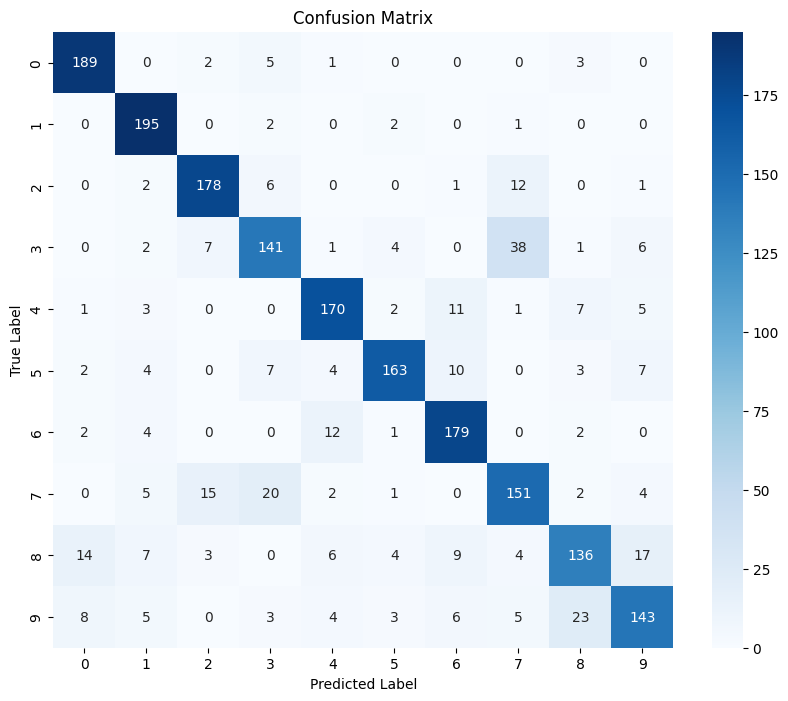


Saving the trained model to knn_digit_model_2.joblib...
Model saved successfully.

Saving the scaler to scaler_digit_model_2.joblib...
Scaler saved successfully.

Training and saving complete.
You can find the saved model file 'knn_digit_model_2.joblib' and scaler file 'scaler_digit_model_2.joblib' in your Colab files sidebar.


In [ ]:
# -*- coding: utf-8 -*-
"""Colab Digit Drawing and Prediction - Training & Setup"""

# Install necessary libraries if you haven't already
# Note: These are usually pre-installed in Colab
# !pip install pandas scikit-learn joblib Pillow

import pandas as pd
import numpy as np
import os # Needed to check if files exist
from collections import deque # For the BFS function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Added ConfusionMatrixDisplay later
import joblib # Recommended for saving scikit-learn models
import matplotlib.pyplot as plt # For plotting the confusion matrix
import seaborn as sns # For nicer confusion matrix visualization

# --- Configuration ---
# Ensure you generate digit_features_2.csv using a modified script first!
CSV_FILE_PATH = 'digit_features_2.csv'
MODEL_SAVE_PATH = 'knn_digit_model_2.joblib'
SCALER_SAVE_PATH = 'scaler_digit_model_2.joblib'

TEST_SIZE = 0.2   # Percentage of data to use for testing (20%)
RANDOM_STATE = 42 # For reproducibility
N_NEIGHBORS = 5 # K value for KNN. This is a hyperparameter you might tune.

# Image dimensions (must match what was used for CSV generation)
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

# BFS Threshold - MUST be the SAME value used in your script to generate digit_features_2.csv
# This value determines what's considered "black" or traversable.
BFS_THRESHOLD = 0.05 # Example threshold. You might tune this slightly if needed.


# --- Feature Extraction Logic (Identical to CSV generation script) ---
# We need these functions defined in this cell because we'll use them implicitly
# by loading the CSV that was generated using this logic.
# The *same* functions will be defined again in Cell 2 for processing drawn images.


def bfs(matrix, direction_func_index, threshold=BFS_THRESHOLD):
    """
    Performs Breadth-First Search on the matrix using a threshold for traversal.
    Traverses pixels where matrix value is < threshold (considered "black").
    """
    rows, cols = matrix.shape
    visited = np.full((rows, cols), False, dtype=bool)
    queue = deque()

    def enqueue_if_valid(x, y):
        if 0 <= x < cols and 0 <= y < rows:
            # Check if not visited and pixel value is BELOW the threshold
            if not visited[y, x] and matrix[y, x] < threshold:
                queue.append((x, y))
                visited[y, x] = True

    # Equivalent direction functions from JS
    def top_pour_neighbors(x, y): # JS index 0
        enqueue_if_valid(x - 1, y) # Left
        enqueue_if_valid(x + 1, y) # Right
        enqueue_if_valid(x, y - 1) # Up

    def bottom_pour_neighbors(x, y): # JS index 1
        enqueue_if_valid(x - 1, y) # Left
        enqueue_if_valid(x + 1, y) # Right
        enqueue_if_valid(x, y + 1) # Down

    def left_pour_neighbors(x, y): # JS index 2
        enqueue_if_valid(x - 1, y) # Left
        enqueue_if_valid(x, y - 1) # Up
        enqueue_if_valid(x, y + 1) # Down

    def right_pour_neighbors(x, y): # JS index 3
        enqueue_if_valid(x + 1, y) # Right
        enqueue_if_valid(x, y - 1) # Up
        enqueue_if_valid(x, y + 1) # Down

    def full_pour_neighbors(x, y): # JS index 4 (4 neighbors as per JS)
        enqueue_if_valid(x - 1, y) # Left
        enqueue_if_valid(x + 1, y) # Right
        enqueue_if_valid(x, y - 1) # Up
        enqueue_if_valid(x, y + 1) # Down


    direction_functions = [
        top_pour_neighbors,
        bottom_pour_neighbors,
        left_pour_neighbors,
        right_pour_neighbors,
        full_pour_neighbors,
    ]

    # Equivalent start positions from JS
    start_positions = [
        (14, 27), # JS index 0: Bottom-center (x, y)
        (14, 0),  # JS index 1: Top-center (x, y)
        (27, 14), # JS index 2: Right-center (x, y)
        (0, 14),  # JS index 3: Left-center (x, y)
        (0, 0)    # JS index 4: Top-left corner (x, y)
    ]

    start_x, start_y = start_positions[direction_func_index]

    # Start BFS if the starting pixel is traversable (below threshold)
    if 0 <= start_x < cols and 0 <= start_y < rows and matrix[start_y, start_x] < threshold:
        queue.append((start_x, start_y))
        visited[start_y, start_x] = True
    # Note: If the start pixel is NOT traversable, the queue starts empty and BFS does nothing.

    current_direction_func = direction_functions[direction_func_index]

    # JS had an arbitrary iteration limit of 785. Keep for equivalence if needed,
    # but a standard BFS will finish when queue is empty.
    # max_iterations = IMAGE_WIDTH * IMAGE_HEIGHT + 1 # 785

    while queue:
        # Optional: check max_iterations here if strictly mimicking JS
        # if iterations > max_iterations: break

        x, y = queue.popleft()
        current_direction_func(x, y)
        # iterations += 1 # Increment if using iterations limit


    return visited # Return the visited matrix (boolean)


# The create_data_vector function is needed for generating the features for the CSV,
# but since we are loading the CSV directly in this cell, we technically only
# need to *load* features here, not *create* them.
# However, we will redefine create_data_vector in Cell 2 for processing the drawn image.
# We keep the BFS definition here as context for how the CSV was created.


# --- Load the Dataset ---
if not os.path.exists(CSV_FILE_PATH):
    print(f"Error: The file '{CSV_FILE_PATH}' was not found.")
    print(f"Please run your modified CSV generation script to create '{CSV_FILE_PATH}' first, and then upload it to your Colab environment.")
    # You can upload by clicking the folder icon on the left sidebar -> Upload
    # sys.exit() # uncomment to stop execution immediately
    df = None # Set df to None to indicate failure
else:
    try:
        df = pd.read_csv(CSV_FILE_PATH)
        print(f"Successfully loaded data from {CSV_FILE_PATH}")
        print("Dataset shape:", df.shape)
        print("\nFirst 5 rows:")
        print(df.head())
        print("\nDataset Info:")
        df.info()
        print("\nDataset Description:")
        print(df.describe())

    except Exception as e:
        print(f"An error occurred while loading the CSV: {e}")
        df = None # Set df to None to indicate failure


# Proceed only if data was loaded successfully
if df is not None and not df.empty:
    # --- Separate Features (X) and Target (y) ---
    # The 'Number' column is our target variable
    X = df.drop('Number', axis=1) # Features are all columns EXCEPT 'Number'
    y = df['Number']             # Target variable

    print("\nFeatures shape (X):", X.shape)
    print("Target shape (y):", y.shape)
    print("\nTarget labels (y):", np.unique(y)) # Should show 0, 1, ..., 9

    # --- Split Data into Training and Testing Sets ---
    # Use stratify=y to ensure equal distribution of classes in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    print(f"\nData split into training ({len(X_train)} samples) and testing ({len(X_test)} samples).")
    print("Training set shapes: X_train", X_train.shape, "y_train", y_train.shape)
    print("Testing set shapes: X_test", X_test.shape, "y_test", y_test.shape)

    # --- 4. Feature Scaling ---
    # Scaling is crucial for distance-based algorithms like KNN
    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()

    # Fit the scaler ONLY on the training data to prevent data leakage
    scaler.fit(X_train) # Scaler now learns mean and std for each feature

    # Transform both training and testing data using the fitted scaler
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("\nFeatures scaled using StandardScaler.")

    # --- 5. Train the KNN Model ---
    print(f"\nTraining KNN model with n_neighbors = {N_NEIGHBORS}...")
    knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)

    # Train the model using the scaled training data
    knn.fit(X_train_scaled, y_train)

    print("KNN model training complete.")

    # --- 6. Evaluate the Model ---
    print("\nEvaluating the model on the test set...")

    # Make predictions on the scaled test data
    y_pred = knn.predict(X_test_scaled)

    # Calculate evaluation metrics

    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification Report (Precision, Recall, F1-score for each class)
    target_names = [str(i) for i in range(10)]
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    # Optional: Plot Confusion Matrix for better visualization
    try:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    except Exception as e:
        print(cm) # Print text matrix if plot fails
        print(f"\nCould not plot confusion matrix: {e}")


    # --- 7. Save the Trained Model and Scaler ---
    print(f"\nSaving the trained model to {MODEL_SAVE_PATH}...")
    try:
        joblib.dump(knn, MODEL_SAVE_PATH)
        print("Model saved successfully.")
    except Exception as e:
         print(f"Error saving model: {e}")


    print(f"\nSaving the scaler to {SCALER_SAVE_PATH}...")
    try:
        joblib.dump(scaler, SCALER_SAVE_PATH)
        print("Scaler saved successfully.")
    except Exception as e:
        print(f"Error saving scaler: {e}")

    print("\nTraining and saving complete.")
    print(f"You can find the saved model file '{MODEL_SAVE_PATH}' and scaler file '{SCALER_SAVE_PATH}' in your Colab files sidebar.")

else:
    print("\nSkipping model training due to data loading issues.")

#loading functions

In [ ]:
# -*- coding: utf-8 -*-
"""Colab Digit Drawing and Prediction - Prediction Setup"""

# These imports are needed here as well
import pandas as pd
import numpy as np
import joblib # For loading the saved model and scaler
import io # To handle image data bytes
import base64 # To decode image data from JavaScript
from PIL import Image # To process the image from the canvas
from collections import deque # For the BFS function
from IPython.display import display, HTML, Javascript # To display HTML/JS and interact
import traceback # For more detailed error messages

# --- Configuration ---
# Paths to the model and scaler saved in Cell 1
MODEL_LOAD_PATH = 'knn_digit_model_2.joblib'
SCALER_LOAD_PATH = 'scaler_digit_model_2.joblib'

# Image dimensions (must match training)
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

# BFS Threshold - MUST be the SAME value used in Cell 1 and CSV generation
BFS_THRESHOLD = 0.05


# --- Load Saved Model and Scaler ---
# We need the model and scaler to be loaded for prediction
knn_model = None
scaler = None
try:
    knn_model = joblib.load(MODEL_LOAD_PATH)
    scaler = joblib.load(SCALER_LOAD_PATH)
    print("Successfully loaded KNN model and Scaler for prediction.")
except FileNotFoundError:
    print(f"Error: Model or scaler file not found.")
    print(f"Please ensure '{MODEL_LOAD_PATH}' and '{SCALER_LOAD_PATH}' exist in your Colab environment.")
    print("These files should have been created by running Cell 1 after generating the CSV.")
except Exception as e:
    print(f"An error occurred while loading model/scaler: {e}")
    print(f"Details: {e}")


# --- Feature Extraction Logic (Identical to CSV generation and Cell 1's internal logic) ---
# These functions will be used by the predict_drawn_digit function


def image_to_matrix_for_drawing(pil_image):
    """
    Converts a PIL Image object (processed to 28x28 grayscale)
    to a 28x28 numpy array with values between 0 and 1.
    """
    if pil_image.mode != 'L':
        pil_image = pil_image.convert('L')

    if pil_image.size != (IMAGE_WIDTH, IMAGE_HEIGHT):
         pil_image = pil_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.Resampling.LANCZOS)

    pixels = np.array(pil_image).astype(np.float32) / 255.0
    matrix = pixels.reshape((IMAGE_HEIGHT, IMAGE_WIDTH))
    return matrix


def bfs(matrix, direction_func_index, threshold=BFS_THRESHOLD):
    """
    Performs Breadth-First Search on the matrix using a threshold for traversal.
    Identical to the function used for training data generation.
    """
    rows, cols = matrix.shape
    visited = np.full((rows, cols), False, dtype=bool)
    queue = deque()

    def enqueue_if_valid(x, y):
        if 0 <= x < cols and 0 <= y < rows:
            if not visited[y, x] and matrix[y, x] < threshold:
                queue.append((x, y))
                visited[y, x] = True

    # Equivalent direction functions from JS
    def top_pour_neighbors(x, y): # JS index 0
        enqueue_if_valid(x - 1, y)
        enqueue_if_valid(x + 1, y)
        enqueue_if_valid(x, y - 1)

    def bottom_pour_neighbors(x, y): # JS index 1
        enqueue_if_valid(x - 1, y)
        enqueue_if_valid(x + 1, y)
        enqueue_if_valid(x, y + 1)

    def left_pour_neighbors(x, y): # JS index 2
        enqueue_if_valid(x - 1, y)
        enqueue_if_valid(x, y - 1)
        enqueue_if_valid(x, y + 1)

    def right_pour_neighbors(x, y): # JS index 3
        enqueue_if_valid(x + 1, y)
        enqueue_if_valid(x, y - 1)
        enqueue_if_valid(x, y + 1)

    def full_pour_neighbors(x, y): # JS index 4 (4 neighbors as per JS)
        enqueue_if_valid(x - 1, y)
        enqueue_if_valid(x + 1, y)
        enqueue_if_valid(x, y - 1)
        enqueue_if_valid(x, y + 1)


    direction_functions = [
        top_pour_neighbors, bottom_pour_neighbors, left_pour_neighbors,
        right_pour_neighbors, full_pour_neighbors,
    ]

    start_positions = [
        (14, 27), (14, 0), (27, 14), (0, 14), (0, 0)
    ]

    start_x, start_y = start_positions[direction_func_index]

    if 0 <= start_x < cols and 0 <= start_y < rows and matrix[start_y, start_x] < threshold:
        queue.append((start_x, start_y))
        visited[start_y, start_x] = True

    current_direction_func = direction_functions[direction_func_index]

    # max_iterations = IMAGE_WIDTH * IMAGE_HEIGHT + 1 # 785
    # iterations = 0

    while queue:
        # if iterations > max_iterations: break # Optional limit

        x, y = queue.popleft()
        current_direction_func(x, y)
        # iterations += 1 # Increment if using limit

    return visited


def create_data_vector(matrix, bfs_threshold=BFS_THRESHOLD):
    """
    Applies BFS and calculates features, matching the logic used for training data.
    Includes revised accumulation logic for FullPour.
    """
    features_map = []
    bfs_direction_indices = [0, 0, 1, 1, 2, 2, 3, 3, 4]

    for i in range(9):
        bfs_dir_idx = bfs_direction_indices[i]
        # Pass the threshold here
        features_map.append(bfs(matrix, bfs_dir_idx, threshold=bfs_threshold))

    data_vector = []
    total_pixels = IMAGE_WIDTH * IMAGE_HEIGHT

    for i in range(9):
        water_accumulation = 0
        current_map = features_map[i]

        if i < 8:
            # Regions based on JS logic interpretation
            even = i % 2 == 0
            vertical = i < 4

            if vertical:
                startX = 0 if even else 14
                endX = 14 if even else 28
                startY = 0
                endY = 28
            else: # Horizontal pours (features 4-7)
                startX = 0
                endX = 28
                startY = 14 if i in [5, 7] else 0
                endY = 14 if i in [4, 6] else 28

            # Count pixels in the region where visited status differs from FullPour map
            full_pour_map = features_map[8]
            for y in range(startY, endY):
                for x in range(startX, endX):
                     if current_map[y, x] != full_pour_map[y, x]:
                         water_accumulation += 1

        else: # i == 8 (FullPour)
             # REVISED LOGIC: Count black pixels (BELOW THRESHOLD) that were NOT visited
             for y in range(IMAGE_HEIGHT):
                 for x in range(IMAGE_WIDTH):
                     # Check original matrix value against threshold for 'blackness'
                     if matrix[y, x] < bfs_threshold and not current_map[y, x]:
                         water_accumulation += 1


        data_vector.append(water_accumulation)

    # Normalize features as in the JS code
    normalization_factor_partial = total_pixels / 4
    normalization_factor_full = total_pixels / 8

    normalized_features_list = [
        data_vector[0] / normalization_factor_partial,
        data_vector[1] / normalization_factor_partial,
        data_vector[2] / normalization_factor_partial,
        data_vector[3] / normalization_factor_partial,
        data_vector[4] / normalization_factor_partial,
        data_vector[5] / normalization_factor_partial,
        data_vector[6] / normalization_factor_partial,
        data_vector[7] / normalization_factor_partial,
        data_vector[8] / normalization_factor_full,
    ]

    return normalized_features_list


# --- Define Python function callable from JavaScript ---

# Define feature names in the correct order for DataFrame creation
feature_names = [
    "TopPourLeftSide", "TopPourRightSide",
    "BottomPourLeftSide", "BottomPourRightSide",
    "LeftPourTopSide", "LeftPourBottomSide",
    "RightPourTopSide", "RightPourBottomSide",
    "FullPour"
]


# Check if model and scaler were loaded before defining and registering
if knn_model is not None and scaler is not None:
    def predict_drawn_digit(base64_data_url):
        """
        Receives base64 image data from JS, processes it, extracts features,
        scales, predicts using the loaded model, and prints the result + debug info.
        This function is called from the JavaScript code.
        """
        try:
            # 1. Decode base64 image data
            img_data = base64_data_url.split(',')[1]
            img_bytes = base64.b64decode(img_data)

            # 2. Open image using PIL
            img = Image.open(io.BytesIO(img_bytes))

            # 3. Process image to 28x28 grayscale and convert to matrix
            img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT), Image.Resampling.LANCZOS)
            matrix = image_to_matrix_for_drawing(img) # Use the 0-1 float matrix

            # --- DEBUG: Inspect the 28x28 matrix ---
            print(f"\n--- Debug: 28x28 Matrix from Drawn Image (0-1 float) ---")
            # Print a representation (e.g., replace > (threshold + 0.05) with # and < (threshold + 0.05) with .)
            # Use a slightly higher threshold for printing visualization
            print_threshold = BFS_THRESHOLD + 0.05
            for r in matrix:
                print("".join(['#' if cell > print_threshold else '.' for cell in r]))
            print(f"Min pixel value: {np.min(matrix):.4f}")
            print(f"Max pixel value: {np.max(matrix):.4f}")
            print(f"Pixels < {BFS_THRESHOLD}: {np.sum(matrix < BFS_THRESHOLD)}")
            print(f"Pixels == 0.0: {np.sum(matrix == 0.0)}")
            print("--------------------------------------------------\n")
            # --- END DEBUG ---


            # 4. Extract features using the replicated logic (with threshold)
            raw_feature_vector_list = create_data_vector(matrix, bfs_threshold=BFS_THRESHOLD)
            # Convert to NumPy array for debugging print if needed, but will use DataFrame for scaling/prediction
            feature_vector_np = np.array(raw_feature_vector_list).reshape(1, -1)


            # --- DEBUG: Inspect the raw feature vector ---
            print(f"\n--- Debug: Raw Feature Vector ---")
            for name, value in zip(feature_names, raw_feature_vector_list):
                 print(f"  {name}: {value:.4f}")
            print("---------------------------------\n")
            # --- END DEBUG ---


            # 5. Scale the feature vector using the loaded scaler
            # Convert to DataFrame to preserve feature names for the scaler
            feature_vector_df = pd.DataFrame(feature_vector_np, columns=feature_names)
            scaled_feature_vector = scaler.transform(feature_vector_df)


            # --- DEBUG: Inspect the scaled feature vector ---
            print(f"\n--- Debug: Scaled Feature Vector (Input to KNN) ---")
            # Print with names for clarity
            scaled_df = pd.DataFrame(scaled_feature_vector, columns=feature_names)
            print(scaled_df.to_string(index=False, float_format='{:.4f}'.format))
            print("-------------------------------------------\n")
            # --- END DEBUG ---


            # 6. Make prediction using the loaded KNN model
            prediction = knn_model.predict(scaled_feature_vector)
            predicted_digit = prediction[0]

            # 7. Print the result in the Colab output
            print(f"\n--- Prediction Result ---")
            print(f"The drawn digit is predicted as: {predicted_digit}")
            print("-------------------------\n")


        except Exception as e:
            print(f"\nAn error occurred during prediction: {e}")
            print("Please try drawing again or check the previous steps and console for details.")
            traceback.print_exc() # Print full traceback for debugging


    # Register the Python function so it can be called from JavaScript
    # The first argument is the name used in JS (e.g., google.colab.kernel.invokeFunction('predict_drawn_digit_py', [...]))
    # The second argument is the Python function object
    from google.colab.output import register_callback
    register_callback('predict_drawn_digit_py', predict_drawn_digit)

    print("\nPython prediction function registered and ready.")

else:
    print("\nSkipping registration of prediction function as model/scaler were not loaded.")

Successfully loaded KNN model and Scaler for prediction.

Python prediction function registered and ready.


#canvas test

In [ ]:
# -*- coding: utf-8 -*-
"""Colab Digit Drawing and Prediction - Canvas UI"""

# Set canvas dimensions - Choose a size comfortable for drawing, not necessarily 28x28
CANVAS_SIZE = 200 # px

# Check if model was loaded successfully in Cell 2 before displaying canvas
# (Strictly speaking, the JS calls the Python func, which checks loading,
# but checking here prevents showing a non-functional UI)
if 'knn_model' in locals() and knn_model is not None and 'scaler' in locals() and scaler is not None:
    canvas_html = f"""
    <h3>Draw a digit (0-9) in the box below:</h3>
    <p>Use white color on the black background.</p>
    <canvas id="drawingCanvas" width="{CANVAS_SIZE}" height="{CANVAS_SIZE}" style="border:1px solid #000000; background-color: black;"></canvas>
    <br>
    <button id="predictButton">Predict Digit</button>
    <button id="clearButton">Clear Canvas</button>
    <div id="predictionOutput" style="margin-top: 10px; font-weight: bold;"></div>

    <script>
            // Get canvas and context
    const canvas = document.getElementById('drawingCanvas');
    const ctx = canvas.getContext('2d');

    // Drawing state
    let isDrawing = false;
    let lastX = 0;
    let lastY = 0;

    // Drawing style (white lines on black background)
    ctx.strokeStyle = '#FFFFFF'; // White color
    ctx.lineWidth = 15;         // Thickness of the line - Adjust if needed
    ctx.lineCap = 'round';      // Rounded ends for lines
    ctx.lineJoin = 'round';     // Rounded corners for lines

    // Function to clear the canvas
    function clearCanvas() {{
        ctx.fillStyle = '#000000'; // Black color
        ctx.fillRect(0, 0, canvas.width, canvas.height);
        document.getElementById('predictionOutput').innerText = ''; // Clear previous prediction message
    }}

    // Initialize canvas with black background
    clearCanvas();

    // Drawing functions
    function draw(e) {{
        if (!isDrawing) return;
        ctx.beginPath();
        ctx.moveTo(lastX, lastY);
        ctx.lineTo(e.offsetX, e.offsetY);
        ctx.stroke();
        [lastX, lastY] = [e.offsetX, e.offsetY];
    }}

    // Event listeners for drawing
    canvas.addEventListener('mousedown', (e) => {{
        isDrawing = true;
        [lastX, lastY] = [e.offsetX, e.offsetY];
        draw(e); // Draw a dot if clicked without moving
    }});

    canvas.addEventListener('mousemove', draw);
    canvas.addEventListener('mouseup', () => isDrawing = false);
    canvas.addEventListener('mouseout', () => isDrawing = false);


    // Function to get image data, normalize, and send to Python
    async function sendForPrediction() {{
        document.getElementById('predictionOutput').innerText = 'Processing...'; // Indicate processing starts

        // --- Digit Normalization Steps ---
        // 1. Create a temporary canvas for processing
        const tempCanvas = document.createElement('canvas');
        const tempCtx = tempCanvas.getContext('2d');

        // 2. Get the pixel data from the drawn canvas
        const drawnImageData = ctx.getImageData(0, 0, canvas.width, canvas.height);
        const pixels = drawnImageData.data;

        // 3. Find the bounding box of the non-black pixels
        let minX = canvas.width, minY = canvas.height, maxX = 0, maxY = 0;
        let foundPixel = false;
        for (let y = 0; y < canvas.height; y++) {{
            for (let x = 0; x < canvas.width; x++) {{
                // Check if the pixel is NOT black (assuming white drawn on black)
                // Check R channel value (for grayscale-like white)
                // We check against 20 to allow for some anti-aliasing or partial pixels
                const i = (y * canvas.width + x) * 4;
                const r = pixels[i];
                const alpha = pixels[i + 3]; // Alpha channel

                // Check if alpha is non-zero AND color is significantly non-black
                if (alpha > 0 && r > 20) {{
                    minX = Math.min(minX, x);
                    minY = Math.min(minY, y);
                    maxX = Math.max(maxX, x);
                    maxY = Math.max(maxY, y);
                    foundPixel = true;
                }}
            }}
        }}

        if (!foundPixel) {{
             document.getElementById('predictionOutput').innerText = 'Please draw a digit.';
             return; // No digit drawn
        }}

        // Add a small padding around the bounding box
        const padding = 5; // Adjust padding as needed
        minX = Math.max(0, minX - padding);
        minY = Math.max(0, minY - padding);
        maxX = Math.min(canvas.width - 1, maxX + padding);
        maxY = Math.min(canvas.height - 1, maxY + padding);

        const digitWidth = maxX - minX + 1;
        const digitHeight = maxY - minY + 1;

        // 4. Determine scaling factor to fit digit within a square area (e.g., 20x20)
        const targetInnerSize = 20; // Scale digit to fit within 20x20 square leaving padding
        const scale = Math.min(targetInnerSize / digitWidth, targetInnerSize / digitHeight);
        const scaledWidth = digitWidth * scale;
        const scaledHeight = digitHeight * scale;

        // 5. Draw the cropped and scaled digit onto a new 28x28 canvas
        tempCanvas.width = 28;
        tempCanvas.height = 28;
        tempCtx.fillStyle = '#000000'; // Black background
        tempCtx.fillRect(0, 0, 28, 28);

        // Calculate centered position on the 28x28 canvas
        const centerX = (28 - scaledWidth) / 2;
        const centerY = (28 - scaledHeight) / 2;

        // Draw the relevant part of the original canvas onto the temporary canvas
        // Parameters: drawImage(image, sx, sy, sWidth, sHeight, dx, dy, dWidth, dHeight)
        tempCtx.drawImage(
            canvas,
            minX, minY, digitWidth, digitHeight, // Source: cropped region on original canvas
            centerX, centerY, scaledWidth, scaledHeight // Destination: centered, scaled region on 28x28 temp canvas
        );


        // 6. Get the image data URL from the normalized 28x28 temporary canvas
        const normalizedImageDataUrl = tempCanvas.toDataURL('image/png');

        // --- END Digit Normalization ---

        // Use the normalized image data URL for prediction
        document.getElementById('predictionOutput').innerText = 'Predicting...';

        try {{
            // Call the Python function with the NORMALIZED image data
            await google.colab.kernel.invokeFunction('predict_drawn_digit_py', [normalizedImageDataUrl]);
            document.getElementById('predictionOutput').innerText = ''; // Clear message after Python finishes

        }} catch (error) {{
            console.error("Error calling Python function:", error);
            document.getElementById('predictionOutput').innerText = 'Prediction failed. Check console.';
        }}
    }}


    // Event listeners for buttons
    document.getElementById('predictButton').addEventListener('click', sendForPrediction);
    document.getElementById('clearButton').addEventListener('click', clearCanvas);

    // Add a tip to the user
    console.log("Canvas initialized. Draw a white digit on the canvas and click 'Predict Digit'.");
    </script>
    """

    # Display the HTML/JavaScript in the Colab output
    display(HTML(canvas_html))
else:
    print("Canvas not displayed because model/scaler were not successfully loaded in Cell 2.")


--- Debug: 28x28 Matrix from Drawn Image (0-1 float) ---
............................
............................
............................
............................
...............##...........
..........########..........
.........#########..........
........##......##..........
.......##.......##..........
.......##.......##..........
.......##.......##..........
.......##.......#...........
.......#############........
.........############.......
.............##....##.......
...........###.....##.......
.........###.......##.......
........###........##.......
........##........##........
........##.......##.........
........##.....###..........
........##...####...........
.........######.............
..........#.................
............................
............................
............................
............................
Min pixel value: 0.0000
Max pixel value: 1.0000
Pixels < 0.05: 674
Pixels == 0.0: 673
--------------------------------------------

#Visual2

In [ ]:
# -*- coding: utf-8 -*-
"""Colab Digit Features Simple Data Visualization"""

# Install necessary libraries if you haven't already
# !pip install pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # For checking file existence

# --- Configuration ---
CSV_FILE_PATH = 'digit_features_2.csv' # Make sure this path is correct

# --- Load the Dataset ---
try:
    df = pd.read_csv(CSV_FILE_PATH)
    print(f"Successfully loaded data from {CSV_FILE_PATH}")
    print("Dataset shape:", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print("\nDataset Description:")
    print(df.describe())

except FileNotFoundError:
    print(f"Error: The file '{CSV_FILE_PATH}' was not found.")
    print("Please upload the 'digit_features_2.csv' file to your Colab environment.")
    df = None # Set df to None to indicate failure
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    df = None # Set df to None to indicate failure

# Exit or skip viz if data wasn't loaded
if df is None or df.empty:
    print("\nData not loaded. Skipping visualizations.")

Successfully loaded data from digit_features_2.csv
Dataset shape: (10000, 10)

First 5 rows:
   TopPourLeftSide  TopPourRightSide  BottomPourLeftSide  BottomPourRightSide  \
0              0.0               0.0                 0.0                  0.0   
1              0.0               0.0                 0.0                  0.0   
2              0.0               0.0                 0.0                  0.0   
3              0.0               0.0                 0.0                  0.0   
4              0.0               0.0                 0.0                  0.0   

   LeftPourTopSide  LeftPourBottomSide  RightPourTopSide  RightPourBottomSide  \
0              0.0                 0.0               0.0                  0.0   
1              0.0                 0.0               0.0                  0.0   
2              0.0                 0.0               0.0                  0.0   
3              0.0                 0.0               0.0                  0.0   
4              


--- Visualizing Feature Distributions per Digit Class (Box Plots) ---


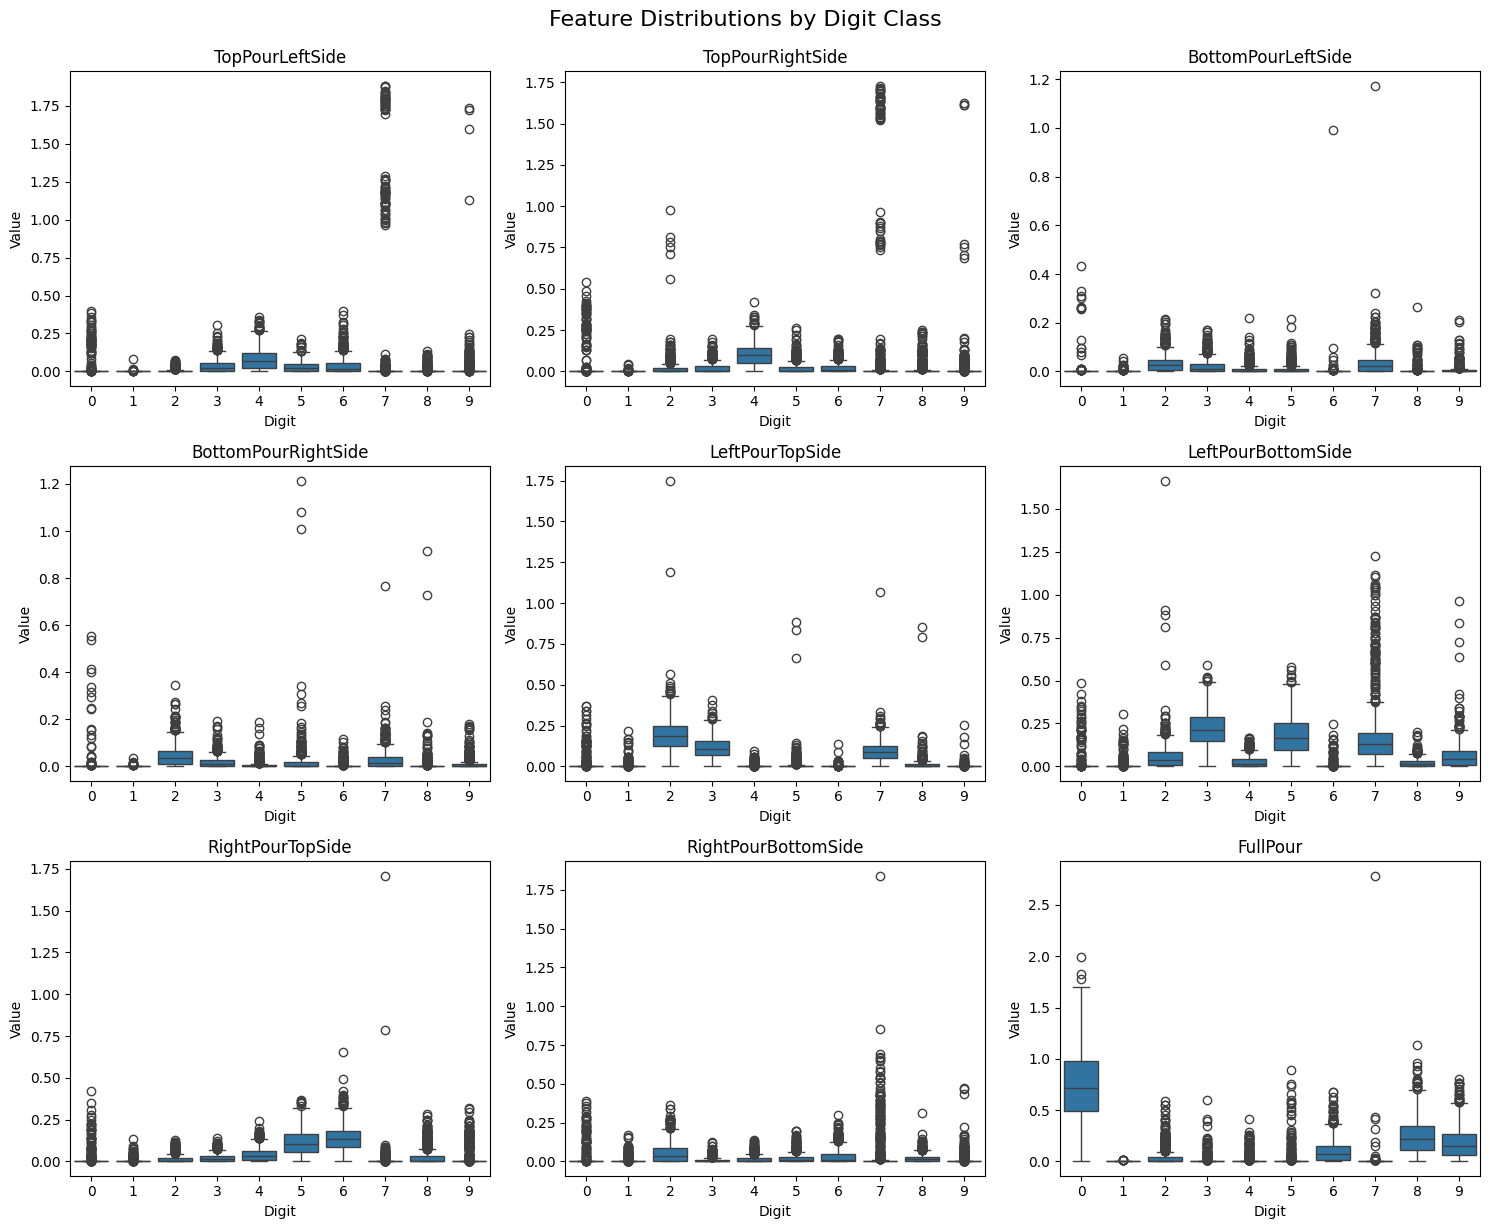


Interpretation:
- Each plot shows the distribution of one feature for each digit (0-9).
- The box represents the interquartile range (IQR), the line inside is the median.
- Look for features where the boxes for different digits are clearly separated.
- Features with well-separated boxes are good discriminators for those digits.
- Features where boxes heavily overlap are less effective discriminators.


In [ ]:
# -*- coding: utf-8 -*-
"""Feature Distribution per Digit Class Visualization (Box Plots)"""

# Skip visualization if data wasn't loaded
if df is not None and not df.empty:
    print("\n--- Visualizing Feature Distributions per Digit Class (Box Plots) ---")

    feature_columns = df.columns.tolist()
    feature_columns.remove('Number')

    # Determine grid size for subplots (e.g., 3 rows, 3 columns for 9 features)
    n_features = len(feature_columns)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols # Calculate rows needed

    plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Adjust figure size based on grid

    for i, col in enumerate(feature_columns):
        plt.subplot(n_rows, n_cols, i + 1)
        # Use `x='Number'` and `y=col` to show distribution of `col` for each `Number`
        sns.boxplot(x='Number', y=col, data=df)
        plt.title(f'{col}') # Keep title short for subplot
        plt.xlabel('Digit')
        plt.ylabel('Value')

    plt.tight_layout()
    plt.suptitle('Feature Distributions by Digit Class', y=1.02, fontsize=16)
    plt.show()

    print("\nInterpretation:")
    print("- Each plot shows the distribution of one feature for each digit (0-9).")
    print("- The box represents the interquartile range (IQR), the line inside is the median.")
    print("- Look for features where the boxes for different digits are clearly separated.")
    print("- Features with well-separated boxes are good discriminators for those digits.")
    print("- Features where boxes heavily overlap are less effective discriminators.")


else:
     print("\nData not available for Feature Distribution per Digit Class Visualization.")


--- Visualizing Average Feature Values per Digit (Heatmap) ---


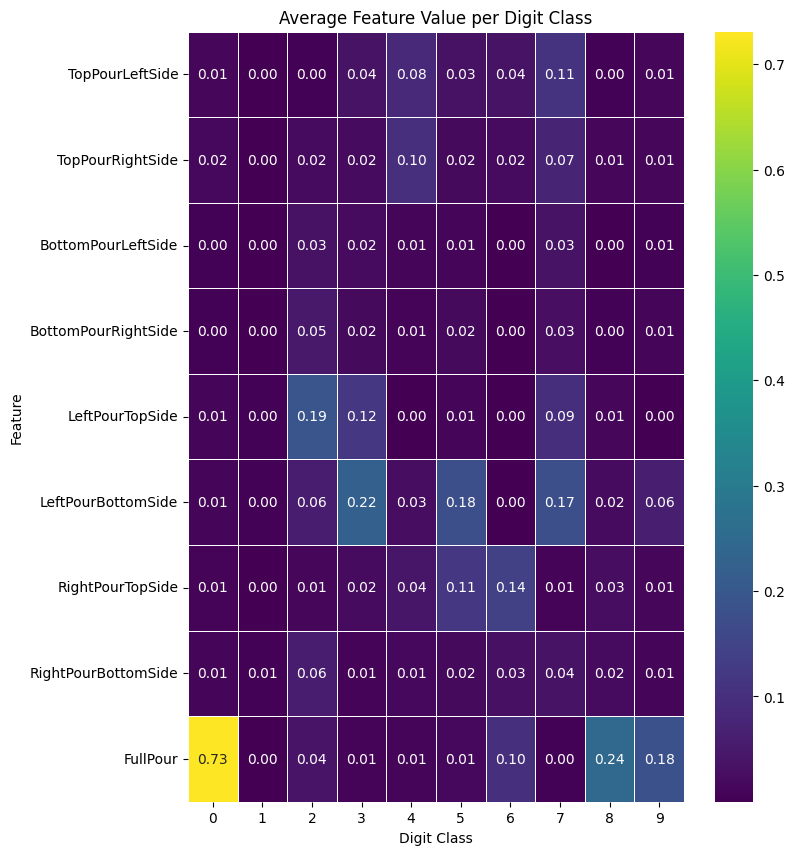


Interpretation:
- Each cell shows the average value of a specific feature for a specific digit.
- Look for rows (features) where the color/value changes significantly across columns (digits).
- A feature is a good discriminator if its average value is very different for different digits.
- For example, if 'FullPour' is high on average for '0' and low for '1', it helps distinguish them.


In [ ]:
# -*- coding: utf-8 -*-
"""Average Feature Values per Digit (Heatmap)"""

# Skip visualization if data wasn't loaded
if df is not None and not df.empty:
    print("\n--- Visualizing Average Feature Values per Digit (Heatmap) ---")

    # Calculate the mean of each feature for each digit
    # Group by 'Number' and calculate the mean for all other columns
    average_features_by_digit = df.groupby('Number').mean()

    # Transpose the result so features are rows and digits are columns
    average_features_by_digit_T = average_features_by_digit.T

    plt.figure(figsize=(8, 10)) # Adjust size for readability
    # Create a heatmap of the average feature values
    sns.heatmap(average_features_by_digit_T, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
    plt.title('Average Feature Value per Digit Class')
    plt.xlabel('Digit Class')
    plt.ylabel('Feature')
    plt.show()

    print("\nInterpretation:")
    print("- Each cell shows the average value of a specific feature for a specific digit.")
    print("- Look for rows (features) where the color/value changes significantly across columns (digits).")
    print("- A feature is a good discriminator if its average value is very different for different digits.")
    print("- For example, if 'FullPour' is high on average for '0' and low for '1', it helps distinguish them.")


else:
     print("\nData not available for Average Feature Values Visualization.")


--- Visualizing Selected Pairwise Feature Scatter Plots ---


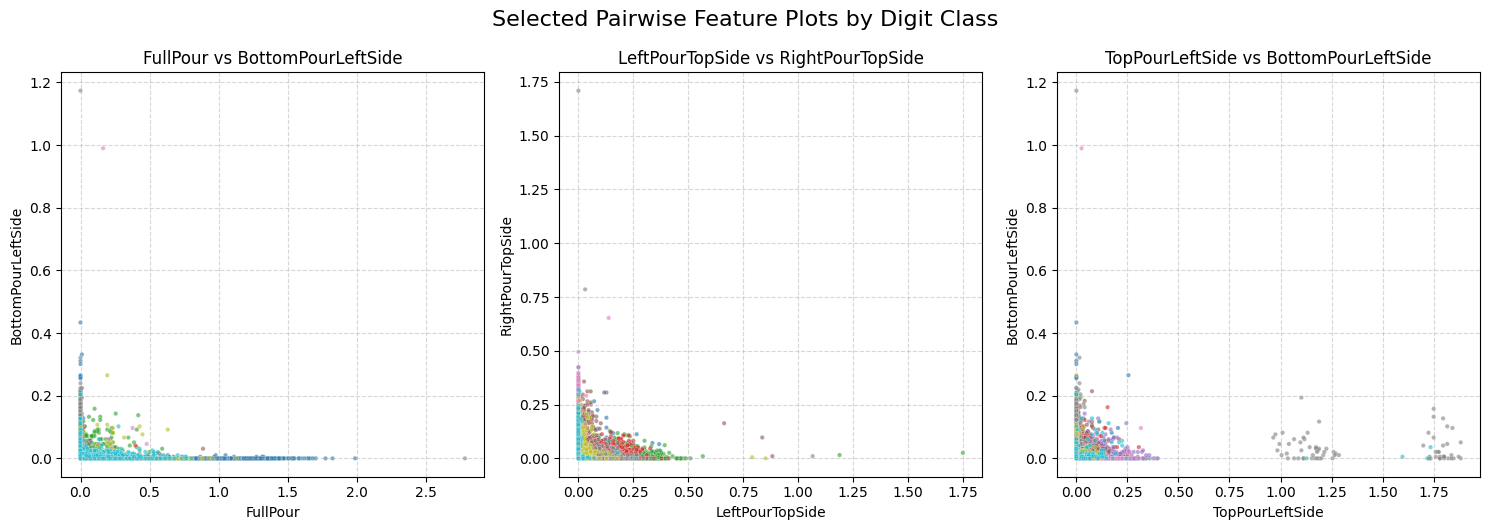


Interpretation:
- Each plot shows data points for two features against each other, colored by digit.
- Look for plots where different colors form distinct clusters or are separated.
- Features that separate digits well in combination will show clearer clusters.
- Overlapping clouds of points indicate that these two features together are not enough to distinguish those digits.


In [ ]:
# -*- coding: utf-8 -*-
"""Selected Pairwise Scatter Plots"""

# Skip visualization if data wasn't loaded
if df is not None and not df.empty:
    print("\n--- Visualizing Selected Pairwise Feature Scatter Plots ---")

    # Choose pairs of features to plot.
    # Try selecting features that showed different distributions in the box plots.
    selected_pairs = [
        ('FullPour', 'BottomPourLeftSide'), # Example: FullPour vs a partial pour
        ('LeftPourTopSide', 'RightPourTopSide'), # Example: Comparing left and right pours
        ('TopPourLeftSide', 'BottomPourLeftSide') # Example: Comparing top and bottom pours
        # Add other pairs you find interesting
    ]

    plt.figure(figsize=(15, 5)) # Figure size for the selected pairs

    for i, (feature1, feature2) in enumerate(selected_pairs):
        plt.subplot(1, len(selected_pairs), i + 1) # Arrange plots side-by-side
        sns.scatterplot(x=feature1, y=feature2, hue='Number', data=df, palette='tab10', legend=False, alpha=0.6, s=10) # s=10 makes points smaller
        plt.title(f'{feature1} vs {feature2}')
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        plt.grid(True, linestyle='--', alpha=0.5)


    plt.tight_layout()
    plt.suptitle('Selected Pairwise Feature Plots by Digit Class', y=1.05, fontsize=16) # Adjust y to make space for legend
    plt.show()

    # Plot a separate legend if needed (can get large with 10 classes)
    # Create dummy points for legend
    # dummy_points = [plt.Line2D([0],[0], marker='o', color=sns.color_palette('tab10')[j], linestyle='', markersize=8, label=str(j)) for j in range(10)]
    # plt.figure(figsize=(10, 1)) # Small figure just for the legend
    # plt.legend(handles=dummy_points, loc='center', ncol=10, title="Digits")
    # plt.axis('off') # Hide axes
    # plt.show()

    print("\nInterpretation:")
    print("- Each plot shows data points for two features against each other, colored by digit.")
    print("- Look for plots where different colors form distinct clusters or are separated.")
    print("- Features that separate digits well in combination will show clearer clusters.")
    print("- Overlapping clouds of points indicate that these two features together are not enough to distinguish those digits.")

else:
     print("\nData not available for Selected Pairwise Scatter Plots.")